<a href="https://colab.research.google.com/github/Krankile/ensemble-forecasting/blob/main/weight_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [1]:
%%capture
!pip install pytorch-forecasting

In [2]:
!pip install kora -q
from kora import drive
drive.link_nbs()

In [72]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import random

import numpy as np
import pandas as pd

from tqdm import tqdm
from pytorch_forecasting.metrics import SMAPE, MAPE
import random

from sklearn.utils import shuffle

import ensemble
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler , minmax_scale



#Build net

In [4]:
class Dense_net(nn.Module):
  
  def __init__(self, in_size, out_size): #Layer list, optimizer should all be part of config 
    super(Dense_net, self).__init__()
    self.fc1 = nn.Linear(in_size, d1)
    self.fc2 = nn.Linear(d1, d2)
    self.fc3 = nn.Linear(d2, out_size)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x/x.sum()

In [171]:
d1 = 32 #this is supposed to be changed by wanb
d2 = 16

#Create training loop

Define the OWA loss function from the M4 competition

In [6]:
def OWA(naive_pred, actual): #Creates a new metric object which has the .loss(y_pred, actual) as a function
  OwA = 0.5*(SMAPE()/SMAPE().loss(naive_pred, actual) + MAPE()/MAPE().loss(naive_pred, actual))
  return OwA

Get data and define data handling helper functions

In [230]:
training_data = pd.read_csv('/content/drive/MyDrive/Master, Ankile og Krange/Data/epic_dataframe_of_doom.csv').set_index("id")

In [8]:
"""Returns a list of pd dataframes of size batch_size"""

def batch_creator(pd_dataframe, batch_size):
  
  if len(pd_dataframe) % batch_size != 0: 
    raise Exception("Batch size not compatible with data length")
  
  shuffled_data = shuffle(pd_dataframe)
  
  batches = []

  for i in range( int(len(shuffled_data)/ batch_size) ):
    batches.append(shuffled_data[i*batch_size:(i+1)*batch_size])

  return batches


In [281]:
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
minmax_scaler.fit(training_data.loc[:, "frequency":"seas_acf1"].to_numpy())


MinMaxScaler(feature_range=(-1, 1))

In [282]:
 def feature_extractor(pd_dataframe_batch, manual_or_auto_toggle, type_of_normalization):
  batch_size = pd_dataframe_batch.shape[0]
  forecasts = pd_dataframe_batch.loc[:, "Random_walk_with_drift_0":"STLM_AR_17"]
  
  if manual_or_auto_toggle == "":
    raise Exception("Manual_or_auto_toggle needs to cointain either m or a for input to be non-empty")
  
  inputs_start = "frequency" if "m" in manual_or_auto_toggle.lower() else "auto_features_0"
  inputs_end = "meta_data_0" if "a" in manual_or_auto_toggle.lower() else "seas_acf1"

  inputs = pd_dataframe_batch.loc[:, inputs_start:inputs_end]
  if type_of_normalization == "minmax":
    inputs_normalized = minmax_scaler.transform(inputs)
  actuals = pd_dataframe_batch.loc[:, "actuals_0":"actuals_17"]
  return torch.Tensor(inputs_normalized), torch.Tensor(forecasts.to_numpy().reshape((batch_size, 7, 18)).swapaxes(1, 2)), torch.Tensor(actuals.to_numpy())



In [245]:
inputs, forecasts, actuals = feature_extractor(training_data.iloc[[109]], "m", "minmax")
#print("LAst input", inputs)
y_pred = net(inputs).unsqueeze(2)
print(y_pred)

       frequency  nperiods  seasonal_period  ...  diff2_acf1  diff2_acf10  seas_acf1
id                                           ...                                    
M7310       12.0       1.0             12.0  ...    -0.40195     0.278249   0.477419

[1 rows x 20 columns]
Normalized inputs:  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 9.70608896e-01
  8.76456102e-05 2.66888301e-01 5.93953996e-01 7.35814055e-01
  1.14751980e-01 6.06842875e-01 6.36363636e-01 9.09090909e-02
  3.28028372e-01 9.74845024e-01 5.60882629e-01 5.89177380e-01
  3.95891157e-02 2.70387436e-01 4.80313898e-02 6.84417536e-01]]
tensor([[[0.2325],
         [0.0000],
         [0.6473],
         [0.0000],
         [0.0000],
         [0.0525],
         [0.0677]]], grad_fn=<UnsqueezeBackward0>)


In [163]:
# 3 modeller, 4 predictions

a = np.array([11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34])
"""
[11, 12, 13, 14,
21, 22, 23, 24,
31, 32, 33, 34]
"""
p = a.reshape((1, 3, 4)).swapaxes(1, 2)

p[0, :, 0]

array([11, 12, 13, 14])

Code to load ensemble models from pickle, manual feature extracton and test data

##Begin training

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [247]:
losses = dict(
    sm=SMAPE(reduction="mean").loss,
    c=nn.CrossEntropyLoss(),
    mse=nn.MSELoss(),
)

In [290]:
def training(training_data, validation_data, net, epochs, batch_size, loss_function_code, print_timing=100, ):
  running_loss = 0.0
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  loss_func = losses[loss_function_code]

  steps = 0
  loss_plot = []
  it = tqdm(range(1, epochs+1))
  for epoch in it:

    # Each epoch has a training and validation phase
    for phase in ['train']: #'val',]:
        
        if phase == 'train':
            net.train(True)  # Set model to training mode
            batches = batch_creator(training_data, batch_size)
        else:
            net.val(False)  # Set model to evaluate mode
            batches = batch_creator(validation_data, batch_size)
          
        for i, batch in enumerate(batches):

          inputs, forecasts, actuals = feature_extractor(batch,"m","minmax")
 
          #print("forecasts:",forecasts.shape)
          optimizer.zero_grad()

          y_pred = net(inputs).unsqueeze(2) #Array containing tensors of weighted average for all forecasts
          #look into how this should be done most elegantly
           
          normalization_weights = actuals[:,0:1]
          
          normalized_actuals = actuals/normalization_weights
          
          prediction = torch.matmul(forecasts, y_pred).squeeze(2) / normalization_weights

          loss = loss_func(prediction, normalized_actuals).mean()
          
          if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

                steps += inputs.shape[0]

          running_loss += loss.item()
          loss_plot.append(loss.item())
          
          it.set_postfix({"loss": loss.item()})
  plt.plot(loss_plot)

Dense_net(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=7, bias=True)
)


100%|██████████| 50/50 [04:03<00:00,  4.87s/it, loss=nan]


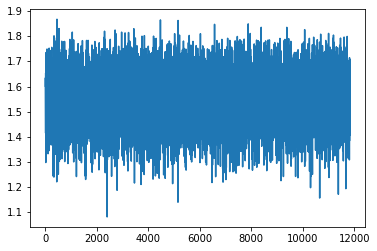

In [291]:
#training_data = pd.read_csv("Monthly-train.csv")  
#validation_data = pd.read_csv("validation-train.csv") 
epochs = 50
batch_size = 10

net = Dense_net(20, 7)
net.train()
print(net)
loss_function_code = "sm" #c, sm or mse 

training(training_data, None, net, epochs, batch_size, loss_function_code ,print_timing=10)

In [285]:
inputs, forecasts, actuals = feature_extractor(training_data.iloc[[12]], "m", "minmax")
y_pred = net(inputs).unsqueeze(2)
print(y_pred)

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.]]], grad_fn=<UnsqueezeBackward0>)


'\n    tensor([[[0.0000],\n         [0.0000],\n         [0.3589],\n         [0.0000],\n         [0.0000],\n         [0.0000],\n         [0.6411]]]'

trained tensor([[[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], grad_fn=<UnsqueezeBackward0>)
untrained tensor([[[0.2164],
         [0.0000],
         [0.2355],
         [0.0000],
         [0.0000],
         [0.5482],
         [0.0000]]], grad_fn=<UnsqueezeBackward0>)


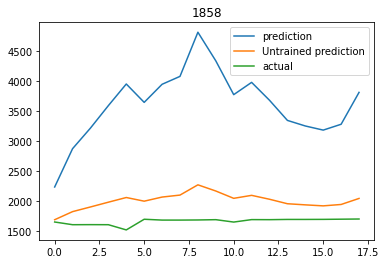

trained tensor([[[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], grad_fn=<UnsqueezeBackward0>)
untrained tensor([[[0.2237],
         [0.0000],
         [0.2234],
         [0.0000],
         [0.0000],
         [0.5529],
         [0.0000]]], grad_fn=<UnsqueezeBackward0>)


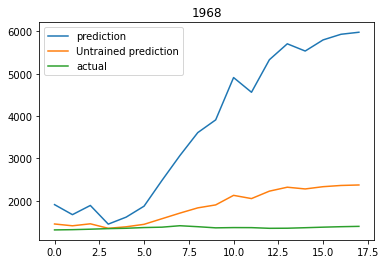

trained tensor([[[1.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], grad_fn=<UnsqueezeBackward0>)
untrained tensor([[[0.2228],
         [0.0000],
         [0.2491],
         [0.0000],
         [0.0000],
         [0.5280],
         [0.0000]]], grad_fn=<UnsqueezeBackward0>)


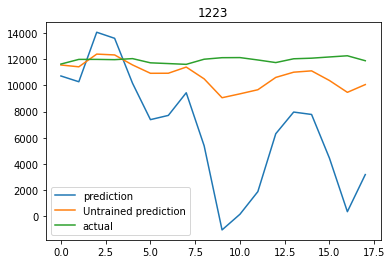

In [289]:
net_untrained = Dense_net(20, 7)

def plot_some_forecast_and_actuals(n_plots):
    for i in random.sample(range(5000), k=n_plots): 
      inputs, forecasts, actuals = feature_extractor(training_data.iloc[[i]], "m", "minmax")
      y_pred = net(inputs).unsqueeze(2)
      y_pred_2 = net_untrained(inputs).unsqueeze(2)
      
      #print("trained", y_pred)
      #print("untrained", y_pred_2)
      
      predictions = torch.matmul(forecasts, y_pred).squeeze(2)
      predictions_un = torch.matmul(forecasts, y_pred_2).squeeze(2)

      plt.title(i)
      plt.plot(predictions.detach().numpy()[0], label="prediction")
      plt.plot(predictions_un.detach().numpy()[0], label="Untrained prediction")
      plt.plot(actuals.detach().numpy()[0], label="actual")
      plt.legend()
      plt.show()

plot_some_forecast_and_actuals(3)